In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
sns.set(font_scale=2.5)

In [4]:
from tqdm import tqdm

## Load data

In [9]:
rating_df = pd.read_csv('data/top-n-movies_user-ratings.csv').drop(columns='Unnamed: 0')

In [6]:
#rating_df.set_index(['movie_id','user_id'], inplace=True)

In [7]:
rating_df.head()

,,rating,movie_title
movie_id,user_id,,
0,307,4,Toy Story
99,250,4,Fargo
180,24,5,Return of the Jedi
287,19,1,Scream
293,31,3,Liar Liar


In [34]:
#top_n_movie_ids = rating_df.movie_id.unique()

## Set some parameters

In [10]:
reward_threshold = 4
n_movies = len(rating_df.movie_id.unique())
n_users = len(rating_df.user_id.unique())
n_visits = 20000
n_iterations = 20

random_seed = 1

## initialize agent value estimator
np.random.seed(random_seed)

# A/B Test

In [12]:
def run_ab_test(rating_df, n_visits, trial_length, iterations=1):

    movie_ids = rating_df.movie_id.unique()
    
    results = []
    
    trial_end = n_visits - trial_length
    
    for i in tqdm(range(0, iterations)):

        ## Agent sample average value estimation 
        n_sampled = np.zeros(n_movies)    
        movie_clicks = np.zeros(n_movies)

        total_clicks = 0
        clicks = np.zeros(n_visits)
        fraction_relevant = np.zeros(n_visits)
        
        for visit in range(0, trial_length):
    
            # get user/movie recommendation
            found_match = False
            while not found_match:

                ## choose a random user to make a recommendation for
                user_id = np.random.randint(n_users)

                ## make a recommendation
                #
                movie_idx = np.random.randint(n_movies)
                
                movie_id = movie_ids[movie_idx]
                
                # if this user rated this movie, count the recommendation
                found_match = len(rating_df.query('movie_id == @movie_id and user_id == @user_id')) > 0
                
            ## get reward
            user_movie_rating = rating_df.query('movie_id == @movie_id and user_id == @user_id').rating.iloc[0]
            if user_movie_rating > reward_threshold:
                reward = 1
            else:
                reward = 0

            ## update value estimate
            n_sampled[movie_idx] += 1
            alpha = 1./n_sampled[movie_idx]
            movie_clicks[movie_idx] += alpha*(reward-movie_clicks[movie_idx])

            ## record metrics
            total_clicks += reward 
            clicks[visit] += total_clicks
            fraction_relevant[visit] = total_clicks * 1. / (visit + 1)
            
            result = {}
            result['iteration'] = i
            result['visit'] = visit
            result['movie_id'] = movie_id
            result['user_id'] = user_id
            result['reward'] = reward
            result['reward_threshold'] = reward_threshold
            result['total_reward'] = total_clicks
            result['fraction_relevant'] = total_clicks * 1. / (visit + 1)
            
            results.append(result)
        
        ab_test_best_movie_idx = np.argmax(movie_clicks)
        ab_test_best_movie_id = movie_ids[ab_test_best_movie_idx]
            
        for visit in range(trial_length, n_visits):
            
            found_match = False
            while not found_match:

                ## choose a random user to make a recommendation for
                user_id = np.random.randint(n_users)

                ## make a recommendation, based on the best result from the A/B test
                movie_id = ab_test_best_movie_id
                
                # if this user rated this movie, count the recommendation
                found_match = len(rating_df.query('movie_id == @movie_id and user_id == @user_id')) > 0
                
            ## get reward
            user_movie_rating = rating_df.query('movie_id == @movie_id and user_id == @user_id').rating.iloc[0]
            if user_movie_rating > reward_threshold:
                reward = 1
            else:
                reward = 0

            ## update value estimate
            n_sampled[movie_idx] += 1
            alpha = 1./n_sampled[movie_idx]
            movie_clicks[movie_idx] += alpha*(reward-movie_clicks[movie_idx])

            ## record metrics
            total_clicks += reward 
            clicks[visit] += total_clicks
            fraction_relevant[visit] = total_clicks * 1. / (visit + 1)
            
            result = {}
            result['iteration'] = i
            result['visit'] = visit
            result['movie_id'] = movie_id
            result['user_id'] = user_id
            result['reward'] = reward
            result['reward_threshold'] = reward_threshold
            result['total_reward'] = total_clicks
            result['fraction_relevant'] = total_clicks * 1. / (visit + 1)
            
            results.append(result)
        
    return pd.DataFrame(results)

In [13]:
ab_test = run_ab_test(rating_df, n_visits, 1000, iterations=n_iterations)

100%|██████████| 20/20 [35:51<00:00, 107.60s/it]


In [41]:
ab_test.head()

,fraction_relevant,iteration,movie_id,reward,reward_threshold,total_reward,user_id,visit
0,1.000000,0,299,1,4,1,767,0
1,1.000000,0,99,1,4,2,144,1
2,0.666667,0,257,0,4,2,276,2
3,0.500000,0,180,0,4,2,907,3
4,0.400000,0,49,0,4,2,580,4


In [14]:
ab_test.to_csv('output/ab_test_1k.csv')

In [15]:
ab_test_avg = ab_test.groupby('visit', as_index=False).mean()

In [534]:
eps_greedy_05pct.head()

,epsilon,fraction_relevant,iteration,movie_id,reward,reward_threshold,total_reward,user_id,visit
0,0.05,1.000000,0,0,1,4,1,20,0
1,0.05,0.500000,0,0,0,4,1,458,1
2,0.05,0.666667,0,0,1,4,2,921,2
3,0.05,0.500000,0,0,0,4,2,212,3
4,0.05,0.400000,0,0,0,4,2,72,4


In [532]:
type(ab_test.query('iteration == {}'.format(iteration_no))[['visit','fraction_relevant']].values[:10])

numpy.ndarray

In [531]:
type(eps_greedy_05pct.query('iteration == {}'.format(iteration_no))[['visit','fraction_relevant']].values[:10])

numpy.ndarray

# $\epsilon$-Greedy Algorithm

In [183]:
def run_epsilon_greedy(n_visits, epsilon, iterations=1):

    results = []
    
    for i in tqdm(range(0, iterations)):

        ## Agent sample average value estimation 
        n_sampled = np.zeros(n_movies)    
        movie_clicks = np.zeros(n_movies)

        total_clicks = 0
        clicks = np.zeros(n_visits)
        fraction_relevant = np.zeros(n_visits)
            
        for visit in range(0, n_visits):

            # get user/movie recommendation
            found_match = False
            while not found_match:

                ## choose a random user to make a recommendation for
                user_id = np.random.randint(n_users)

                # make a recommendation
                #
                ## decide to explore or exploit
                if np.random.uniform() < epsilon:
                    # explore
                    movie_idx = np.random.randint(n_movies)
                else:
                    # exploit
                    movie_idx = np.argmax(movie_clicks)

                movie_id = top_n_movie_ids[movie_idx]
                
                # if this user rated this movie, count the recommendation
                found_match = user_id in top_n_movies.loc[movie_id].index
                
            ## get reward
            user_movie_rating = top_n_movies.loc[movie_id, user_id].rating
            if user_movie_rating > reward_threshold:
                reward = 1
            else:
                reward = 0

            ## update value estimate
            n_sampled[movie_idx] += 1
            alpha = 1./n_sampled[movie_idx]
            movie_clicks[movie_idx] += alpha*(reward-movie_clicks[movie_idx])

            ## record metrics
            total_clicks += reward 
            clicks[visit] += total_clicks
            fraction_relevant[visit] = total_clicks * 1. / (visit + 1)
            
            result = {}
            result['iteration'] = i
            result['epsilon'] = epsilon
            result['visit'] = visit
            result['movie_id'] = movie_id
            result['user_id'] = user_id
            result['reward'] = reward
            result['reward_threshold'] = reward_threshold
            result['total_reward'] = total_clicks
            result['fraction_relevant'] = total_clicks * 1. / (visit + 1)
            
            results.append(result)
        
    return pd.DataFrame(results)

In [191]:
eps_greedy_02pct = run_epsilon_greedy(n_visits, 0.02, n_iterations)
eps_greedy_05pct = run_epsilon_greedy(n_visits, 0.05, n_iterations)
eps_greedy_10pct = run_epsilon_greedy(n_visits, 0.1, n_iterations)
eps_greedy_15pct = run_epsilon_greedy(n_visits, 0.15, n_iterations)

100%|██████████| 20/20 [09:46<00:00, 29.32s/it]


In [192]:
# save the output to a CSV file
pd.concat([eps_greedy_02pct, eps_greedy_05pct, eps_greedy_10pct, eps_greedy_15pct]) \
    .to_csv('output/epsilon_greedy.csv')

In [152]:
eps_greedy_10pct.head()

,epsilon,fraction_relevant,iteration,movie_id,reward,total_reward,user_id,visit
0,0.1,1.000000,0,0,1,1,869,0
1,0.1,0.500000,0,0,0,1,808,1
2,0.1,0.333333,0,0,0,1,526,2
3,0.1,0.250000,0,0,0,1,933,3
4,0.1,0.200000,0,0,0,1,265,4


In [306]:
# combine the iterations to get averages
#
eps_greedy_02pct_avg = eps_greedy_02pct.groupby(by='visit').mean()
eps_greedy_05pct_avg = eps_greedy_05pct.groupby(by='visit').mean()
eps_greedy_10pct_avg = eps_greedy_10pct.groupby(by='visit').mean()
eps_greedy_15pct_avg = eps_greedy_15pct.groupby(by='visit').mean()

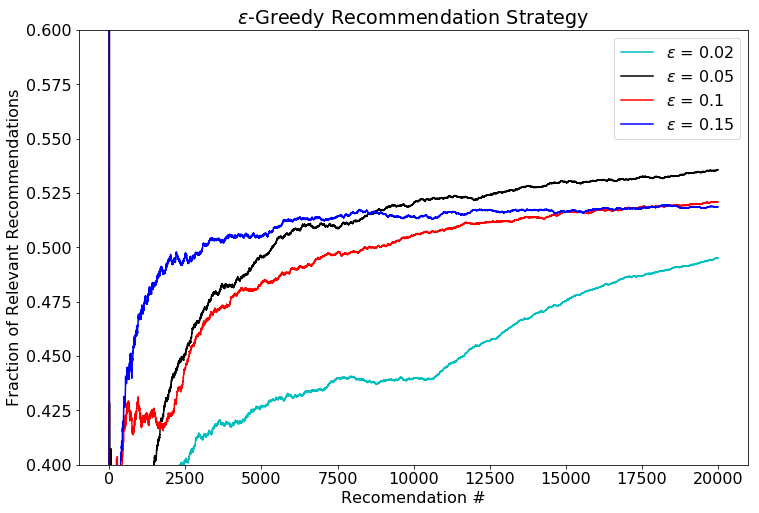

In [354]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('$\epsilon$-Greedy Recommendation Strategy')
ax.set_xlabel('Recomendation #')
ax.set_ylabel('Fraction of Relevant Recommendations')
ax.set_ylim(0.4, 0.6)

iteration_no = 1

for (df,style) in [(eps_greedy_02pct, 'c-'),
                   (eps_greedy_05pct, 'k-'),
                   (eps_greedy_10pct, 'r-'),
                   (eps_greedy_15pct, 'b-')]:

    ax.plot(df.query('iteration == {}'.format(iteration_no))[['visit','fraction_relevant']].values,
            style,
            label='$\epsilon$ = {}'.format(df.epsilon[0])
           )

ax.legend()

In [355]:
fig.savefig('output/images/eps_greedy_all-no-avg.png', transparent=False)

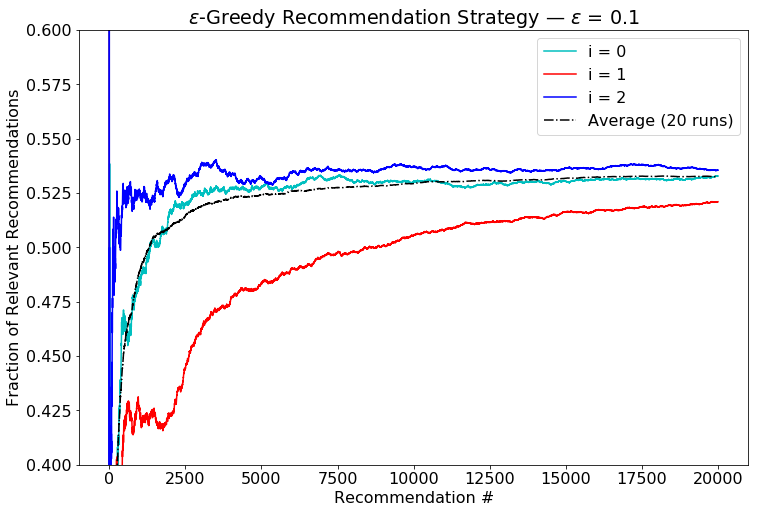

In [356]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('$\epsilon$-Greedy Recommendation Strategy {} $\epsilon$ = 0.1'.format(u'\u2014'))
ax.set_xlabel('Recommendation #')
ax.set_ylabel('Fraction of Relevant Recommendations')
ax.set_ylim(0.4, 0.6)

series_markers = ['c-','r-','b-']

for iteration_no in range(0,3):
    ax.plot(eps_greedy_10pct.query('iteration == {}'.format(iteration_no))[['visit','fraction_relevant']].values,
            series_markers[iteration_no],
            label='i = {}'.format(iteration_no))
    
# add the average for this epsilon
ax.plot(eps_greedy_10pct_avg.fraction_relevant, 'k-.', label='Average ({} runs)'.format(n_iterations))

ax.legend()

In [359]:
fig.savefig('output/images/eps_greedy_10-w-avg.png', transparent=False)

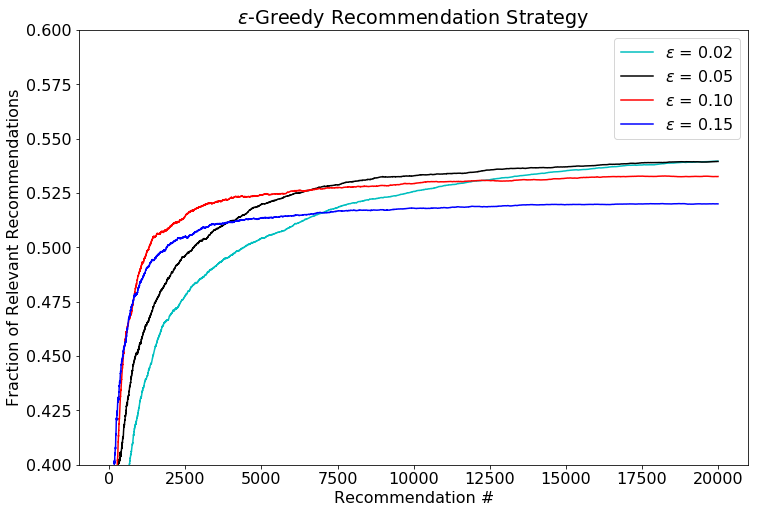

In [360]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('$\epsilon$-Greedy Recommendation Strategy')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('Fraction of Relevant Recommendations')
ax.set_ylim(0.4, 0.6)

for (df,style) in [(eps_greedy_02pct_avg, 'c-'),  # cyan
                   (eps_greedy_05pct_avg, 'k-'),  # black
                   (eps_greedy_10pct_avg, 'r-'),  # red
                   (eps_greedy_15pct_avg, 'b-')]: # blue
    
    ax.plot(df.fraction_relevant, style, label='$\epsilon$ = {:.2f}'.format(df.epsilon[0]))

ax.legend()

In [361]:
fig.savefig('output/images/eps_greedy_all-w-avg.png', transparent=False)

# Thompson Sampling Algorithm

In [362]:
def run_thompson_sampling(n_visits, iterations=1):

    results = []
    
    for i in tqdm(range(0, iterations)):

        ## Agent sample average value estimation 
        alphas = np.ones(n_movies)
        betas = np.ones(n_movies)
        
        total_clicks = 0
        clicks = np.zeros(n_visits)
        fraction_relevant = np.zeros(n_visits)
        
        for visit in range(0, n_visits):

            # get user/movie recommendation
            found_match = False
            while not found_match:

                ## choose a random user to make a recommendation for
                user_id = np.random.randint(n_users)

                # make a recommendation
                #
                samples = [np.random.beta(a,b) for a,b in zip(alphas, betas)]
                movie_idx = np.argmax(samples)

                movie_id = top_n_movie_ids[movie_idx]
                
                # if this user rated this movie, count the recommendation
                found_match = user_id in top_n_movies.loc[movie_id].index
                
            ## get reward
            user_movie_rating = top_n_movies.loc[movie_id, user_id].rating
            if user_movie_rating > reward_threshold:
                reward = 1
            else:
                reward = 0

            ## update value estimate
            if reward == 1:
                alphas[movie_idx] += 1
            else:
                betas[movie_idx] += 1

            ## record metrics
            total_clicks += reward
            clicks[visit] += total_clicks
            fraction_relevant[visit] = total_clicks * 1. / (visit + 1)
            
            result = {}
            result['iteration'] = i
            result['visit'] = visit
            result['movie_id'] = movie_id
            result['user_id'] = user_id
            result['reward'] = reward
            result['reward_threshold'] = reward_threshold
            result['total_reward'] = total_clicks
            result['fraction_relevant'] = total_clicks * 1. / (visit + 1)
            
            results.append(result)
        
    return pd.DataFrame(results)

In [239]:
thompson_sampling = run_thompson_sampling(n_visits, iterations=n_iterations)

100%|██████████| 20/20 [09:30<00:00, 28.54s/it]


In [220]:
thompson_sampling.head()

,fraction_relevant,iteration,movie_id,reward,reward_threshold,total_reward,user_id,visit
0,1.000000,0,49,1,4,1,0,0
1,0.500000,0,287,0,4,1,698,1
2,0.666667,0,49,1,4,2,805,2
3,0.750000,0,99,1,4,3,302,3
4,0.600000,0,99,0,4,3,933,4


In [246]:
# save the output to a CSV file
thompson_sampling.to_csv('output/thompson_sampling.csv')

In [442]:
thompson_sampling_avg = thompson_sampling.groupby(by='visit').mean()

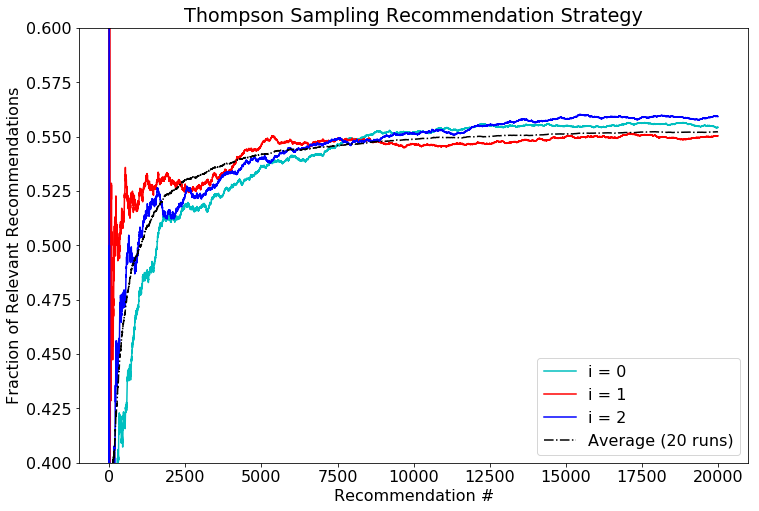

In [363]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Thompson Sampling Recommendation Strategy')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('Fraction of Relevant Recommendations')
ax.set_ylim(0.4, 0.6)

series_markers = ['c-','r-','b-']

for iteration_no in range(0,3):
    ax.plot(thompson_sampling
                .query('iteration == {}'.format(iteration_no))[['visit','fraction_relevant']]
                .values,
            series_markers[iteration_no],
            label='i = {}'.format(iteration_no))
    
# add the average for this epsilon
ax.plot(thompson_sampling_avg.fraction_relevant, 'k-.', label='Average ({} runs)'.format(n_iterations))

ax.legend()

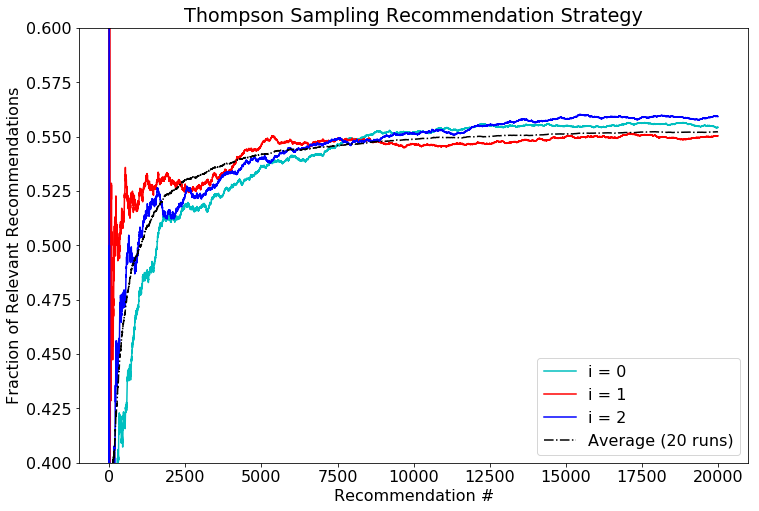

In [363]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Thompson Sampling Recommendation Strategy')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('Fraction of Relevant Recommendations')
ax.set_ylim(0.4, 0.6)

series_markers = ['c-','r-','b-']

for iteration_no in range(0,3):
    ax.plot(thompson_sampling
                .query('iteration == {}'.format(iteration_no))[['visit','fraction_relevant']]
                .values,
            series_markers[iteration_no],
            label='i = {}'.format(iteration_no))
    
# add the average for this epsilon
ax.plot(thompson_sampling_avg.fraction_relevant, 'k-.', label='Average ({} runs)'.format(n_iterations))

ax.legend()

In [364]:
fig.savefig('output/images/thompson_0-2-w-avg.png', transparent=False)

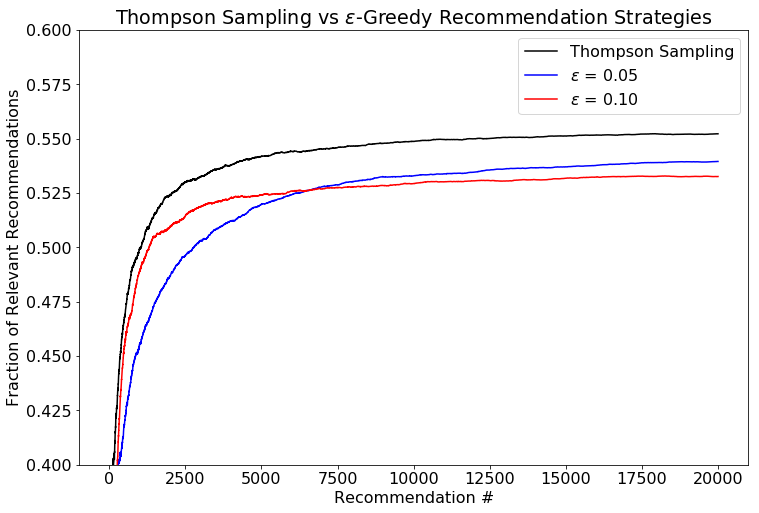

In [371]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Thompson Sampling vs $\epsilon$-Greedy Recommendation Strategies'.format(n_iterations))
ax.set_xlabel('Recommendation #')
ax.set_ylabel('Fraction of Relevant Recommendations')
ax.set_ylim(0.4, 0.6)

ax.plot(thompson_sampling_avg.fraction_relevant, 'k-') # black

ax.plot(eps_greedy_05pct_avg.fraction_relevant, 'b-') # blue
ax.plot(eps_greedy_10pct_avg.fraction_relevant, 'r-') # red

ax.legend(['Thompson Sampling',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10'])

In [372]:
fig.savefig('output/images/thompson_w_eps_greedy_all-avg.png', transparent=False)